In [29]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import numpy as np, pandas as pd, scipy
import astropy
from astropy import units as u
import astromet
#from astromet.track import design_matrix, design_1d
#import dev.astromet.astromet as astromet
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import scanninglaw.times
from scanninglaw.source import Source

In [31]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=2
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5

In [32]:
dr3Period=34/12 # in years
mas=astromet.mas # conversion from degrees to milli-arcseconds

# Load in scanning law
- Requires scanninglaw installed
- Takes up a bit of memory (~1Gb I think)

In [33]:
# slooow step - see scanning_law package for details
dr3_sl=scanninglaw.times.dr2_sl(version='dr3_nominal')

Loading auxilliary data ...
t = 77.186 s
  auxilliary:  40.923 s
          sf:  12.708 s
interpolator:  23.555 s


# Single source

In [165]:
# System astrometry parameters
params=astromet.params()
params.ra=360*np.random.rand()
params.dec=np.arcsin(-1+2*np.random.rand())*180/np.pi
params.parallax=10*np.power(np.random.rand(),-1/3) # all within 100 pc
params.pmrac=params.parallax*(20/3)*np.random.randn()
params.pmdec=params.parallax*(20/3)*np.random.randn()

mag=np.random.rand()*6+15

c=Source(params.ra,params.dec,unit='deg')
sl=dr3_sl(c, return_times=True, return_angles=True)
ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
sort=np.argsort(ts)
ts=ts[sort]
phis=np.squeeze(np.hstack(sl['angles']))[sort]

In [166]:
drac_track, ddec_track=astromet.track(ts,params)

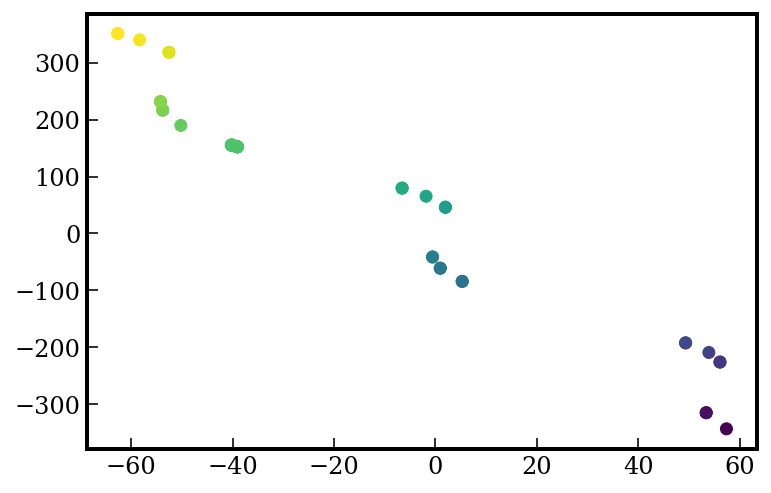

In [167]:
plt.scatter(drac_track, 
            ddec_track, c=ts)

In [168]:
x_true = drac_track * np.sin(np.deg2rad(phis)) + ddec_track * np.cos(np.deg2rad(phis))
x_err = astromet.sigma_ast(mag)
# gaia makes 9 measurements per transit (with random error)
t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.gaia_mock(ts,phis,drac_track,ddec_track,err=x_err)

In [169]:
params.ra, params.dec, params.parallax, params.pmrac, params.pmdec

(92.67831452274784,
 -1.9966020005904592,
 11.694885237037626,
 -53.535124941707345,
 265.2770625902137)

In [170]:
# 'pmra' in gaia data is pmra*cos(dec) 
gaia_output=astromet.gaia_fit(t_obs,x_obs,phi_obs,x_err,params.ra,params.dec)
gaia_output

{'astrometric_matched_transits': 46,
 'visibility_periods_used': 17,
 'astrometric_n_obs_al': 414,
 'astrometric_params_solved': 31,
 'ra': 92.67831452542667,
 'ra_error': 0.005209727860097124,
 'dec': -1.9966020012302033,
 'dec_error': 0.004851217781678837,
 'ra_dec_corr': 0.17684155921803477,
 'parallax': 11.688026851697728,
 'parallax_error': 0.00664908478195482,
 'ra_parallax_corr': 0.14228202128740683,
 'dec_parallax_corr': 0.3551682480615465,
 'pmra': -53.54064703925543,
 'pmra_error': 0.006657094787744046,
 'ra_pmra_corr': -0.17244450335737793,
 'dec_pmra_corr': 0.2396055775649818,
 'parallax_pmra_corr': -0.03243209749496877,
 'pmdec': 265.27942936594,
 'pmdec_error': 0.0060384338302258665,
 'ra_pmdec_corr': 0.17853598756593494,
 'dec_pmdec_corr': -0.4525728469367694,
 'parallax_pmdec_corr': -0.23776372808980695,
 'pmra_pmdec_corr': -0.05958425084774613,
 'astrometric_excess_noise': 0.0,
 'astrometric_chi2_al': 406.28781773733067,
 'astrometric_n_good_obs_al': 414,
 'UWE': 0.996

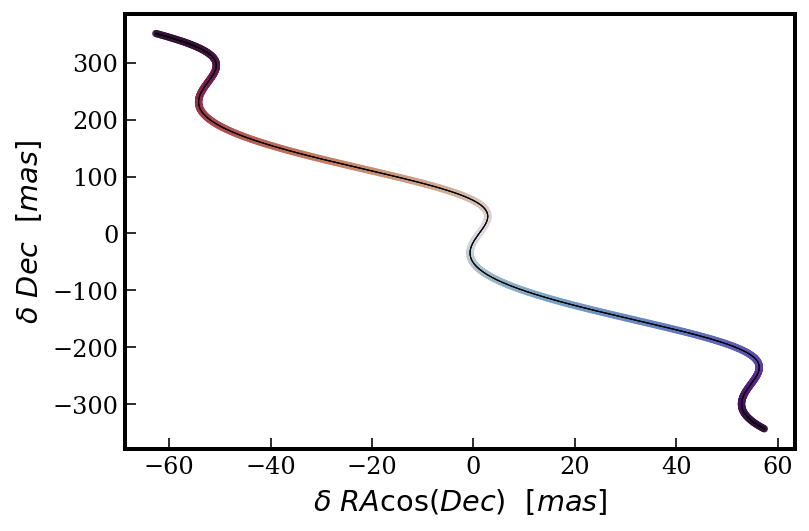

In [171]:
# optionally plot tracks
plotts=np.linspace(ts[0],ts[-1],1000)
cs=mpl.cm.twilight_shifted(np.interp(plotts,[plotts[0],plotts[-1]],[0,1]))

plotRacs,plotDecs=astromet.track(plotts,params)

ax=plt.gca()
fitparams=astromet.params()
for i in range(16):
    fitparams.ra=gaia_output['ra']
    +np.random.randn()*gaia_output['ra_error']*mas/np.cos(np.deg2rad(gaia_output['dec']))
    fitparams.dec=gaia_output['dec']+np.random.randn()*gaia_output['dec_error']*mas
    fitparams.pmrac=gaia_output['pmra']+np.random.randn()*gaia_output['pmra_error']
    fitparams.pmdec=gaia_output['pmdec']+np.random.randn()*gaia_output['pmdec_error']
    fitparams.parallax=gaia_output['parallax']+np.random.randn()*gaia_output['parallax_error']

    fitRacs,fitDecs=astromet.track(plotts,fitparams)
    ax.plot(fitRacs,fitDecs,c='k',alpha=0.2,lw=0.5)
ax.scatter(plotRacs,plotDecs,c=cs,s=10,alpha=0.8)
ax.set_xlabel(r'$\delta \ RA \cos(Dec) \ \ [mas]$')
ax.set_ylabel(r'$\delta \ Dec \ \ [mas]$')

plt.show()

### UWE~1 and astrometric_excess_noise is small (as expected without binary motion)

# Binary source

In [241]:
# System astrometry parameters
params=astromet.params()
params.ra=360*np.random.rand()
params.dec=np.arcsin(-1+2*np.random.rand())*180/np.pi
params.parallax=10*np.power(np.random.rand(),-1/3) # all within 100 pc
params.pmrac=params.parallax*np.random.normal(scale=6.67)
params.pmdec=params.parallax*np.random.normal(scale=6.67)

params.rac = params.ra*np.cos(np.deg2rad(params.dec))

params.phot_g_mean_mag=np.random.rand()*6+10

c=Source(params.ra,params.dec,unit='deg')
sl=dr3_sl(c, return_times=True, return_angles=True)
ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
sort=np.argsort(ts)
ts=ts[sort]
phis=np.squeeze(np.hstack(sl['angles']))[sort]

params.period=100#10**(-1.5+3*np.random.rand()) # periods between 0.03 and 30 years
params.l=np.random.rand() # uniform light ratio
params.q=4*np.random.rand()**2 # mass ratios between 0 and 4 (half less than 1)
params.a=10*np.random.rand()**2
params.e=np.random.rand()
params.vtheta=np.arccos(-1+2*np.random.rand())
params.vphi=2*np.pi*np.random.rand()
params.vomega=2*np.pi*np.random.rand()
orbitalPhase=np.random.rand() # fraction of an orbit completed at t=0
params.tperi=params.period*orbitalPhase

In [242]:
rac_track, dec_track=astromet.track(ts,params)

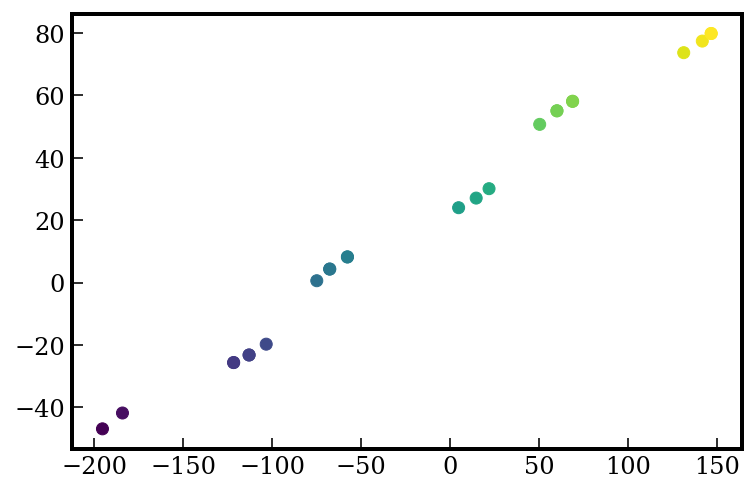

In [243]:
plt.scatter(rac_track, dec_track, c=ts)

In [244]:
x_true = rac_track * np.sin(np.deg2rad(phis)) + dec_track * np.cos(np.deg2rad(phis))
x_err = astromet.sigma_ast(mag)
t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.gaia_mock(ts,phis,rac_track,dec_track,err=x_err)

In [245]:
params.ra, params.dec, params.parallax, params.pmrac, params.pmdec

(102.57376398009998,
 17.959645376964836,
 10.17225643454041,
 123.26439014639668,
 48.530277236789864)

In [246]:
# 'pmra' in gaia data is pmra*cos(dec) 
gaia_output=astromet.gaia_fit(t_obs,x_obs,phi_obs,x_err,params.ra,params.dec)
gaia_output

{'astrometric_matched_transits': 24,
 'visibility_periods_used': 16,
 'astrometric_n_obs_al': 216,
 'astrometric_params_solved': 31,
 'ra': 102.57375646620193,
 'ra_error': 0.0065203382757048275,
 'dec': 17.959649692340715,
 'dec_error': 0.0057031585366216315,
 'ra_dec_corr': -0.06947058325226764,
 'parallax': 10.183589813722985,
 'parallax_error': 0.007042770695002516,
 'ra_parallax_corr': 0.06699833760958365,
 'dec_parallax_corr': 0.23976575617768958,
 'pmra': 122.48213308210784,
 'pmra_error': 0.00810471390739889,
 'ra_pmra_corr': -0.04712419492528723,
 'dec_pmra_corr': 0.17423541032992615,
 'parallax_pmra_corr': -0.03664323106035755,
 'pmdec': 48.598299878390534,
 'pmdec_error': 0.006478135453621746,
 'ra_pmdec_corr': 0.1714355074602747,
 'dec_pmdec_corr': -0.21524551684400556,
 'parallax_pmdec_corr': -0.04918339353374183,
 'pmra_pmdec_corr': -0.10898890378294686,
 'astrometric_excess_noise': 0.0,
 'astrometric_chi2_al': 192.1108950890424,
 'astrometric_n_good_obs_al': 216,
 'UWE':

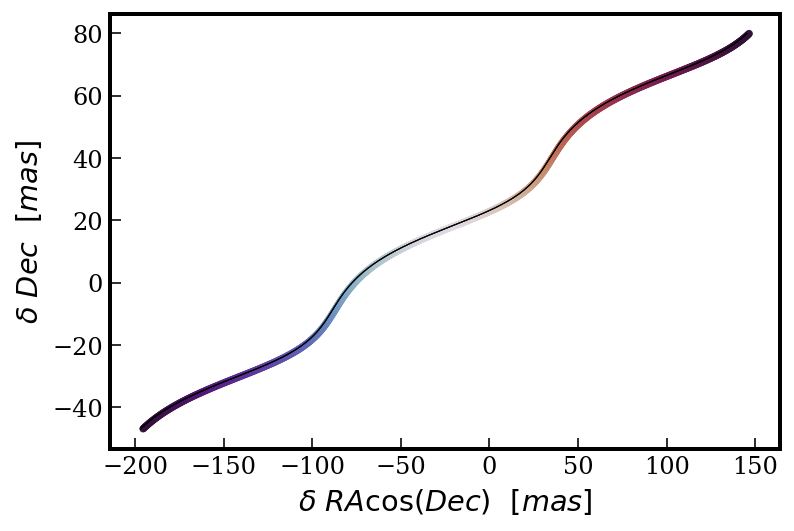

In [254]:
# optionally plot tracks
plotts=np.linspace(ts[0],ts[-1],1000)
cs=mpl.cm.twilight_shifted(np.interp(plotts,[plotts[0],plotts[-1]],[0,1]))

plotRacs,plotDecs=astromet.track(plotts,params)

ax=plt.gca()
fitparams=astromet.params()
for i in range(16):
    fitparams.ra=gaia_output['ra']
    #+np.random.randn()*gaia_output['ra_error']*mas/np.cos(np.deg2rad(gaia_output['dec']))
    fitparams.dec=gaia_output['dec']#+np.random.randn()*gaia_output['dec_error']*mas
    fitparams.pmrac=gaia_output['pmra']#+np.random.randn()*gaia_output['pmra_error']
    fitparams.pmdec=gaia_output['pmdec']#+np.random.randn()*gaia_output['pmdec_error']
    fitparams.parallax=gaia_output['parallax']#+np.random.randn()*gaia_output['parallax_error']

    fitRacs,fitDecs=astromet.track(plotts,fitparams)
    racdiff=(gaia_output['ra']-params.ra)/(mas*np.cos(np.deg2rad(params.dec)))
    decdiff=(gaia_output['dec']-params.dec)/mas
    ax.plot(fitRacs+racdiff,fitDecs+decdiff,c='k',alpha=0.2,lw=0.5)
ax.scatter(plotRacs,plotDecs,c=cs,s=10,alpha=0.8)
ax.set_xlabel(r'$\delta \ RA \cos(Dec) \ \ [mas]$')
ax.set_ylabel(r'$\delta \ Dec \ \ [mas]$')

plt.show()

### UWE is bigger and astrometric_excess_noise>0!

# Iterate over many sources

In [49]:
nTest=100

# Construct Gaia data model
astrometry_coords = ['ra','dec','parallax','pmra','pmdec']
astrometry_gaia = astrometry_coords + \
                [astrometry_coords[i]+'_error' for i in range(5)] + \
                [astrometry_coords[i]+'_'+astrometry_coords[j]+'_corr' for i in range(5) for j in range(i+1,5)] + \
                ['astrometric_excess_noise', 'astrometric_chi2_al', 
                 'astrometric_n_good_obs_al', 'astrometric_n_obs_al',
                 'astrometric_matched_transits', 'visibility_periods_used', 'astrometric_params_solved']


dataNames=['rac_true','dec_true','pmrac_true','pmdec_true','parallax_true','phot_g_mean_mag',
           'M_tot','q','l','a','e','P','tPeri',
           'vTheta','vPhi','vOmega',
           'predict_dTheta','simple_dTheta',
           'sigma_al','sigma_ac','UWE']+astrometry_gaia
allData=astropy.table.Table(names=dataNames)

# we'll generate nTest sets of parameters, and test each with a 0, 2 ,5 and 10 mSun BH
for i in tqdm.notebook.tqdm(range(nTest)):
    allData.add_row()
    thisRow=allData[i]
    
    # System astrometry & photometry parameters
    params=astromet.params()
    params.ra=360*np.random.rand()
    params.dec=np.arcsin(-1+2*np.random.rand())*180/np.pi
    params.parallax=10*np.power(np.random.rand(),-1/3) # all within 100 pc
    params.pmra=params.parallax*np.random.normal(scale=6.67)
    params.pmdec=params.parallax*np.random.normal(scale=6.67)
    params.phot_g_mean_mag=np.random.rand()*6+15    
    
    params.rac = params.ra*np.cos(np.deg2rad(params.dec))
    params.pmra = params.pmrac/np.cos(np.deg2rad(params.dec))
    
    # Scanning law information
    c=Source(params.ra,params.dec,unit='deg')
    sl=dr3_sl(c, return_times=True, return_angles=True)
    ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
    sort=np.argsort(ts)
    ts=ts[sort]
    phis=np.squeeze(np.hstack(sl['angles']))[sort]
    
    # Binary parameters
    params.period=10**(-1.5+3*np.random.rand()) # periods between 0.03 and 30 years
    params.l=np.random.rand() # uniform light ratio
    params.q=4*np.random.rand()**2 # mass ratios between 0 and 4 (half less than 1)
    params.a=10*np.random.rand()**2
    params.e=np.random.rand()
    params.vtheta=np.arccos(-1+2*np.random.rand())
    params.vphi=2*np.pi*np.random.rand()
    params.vomega=2*np.pi*np.random.rand()
    orbitalPhase=np.random.rand() # fraction of an orbit completed at t=0
    params.tperi=params.period*orbitalPhase
    
    # Calculate track
    drac_track, ddec_track = astromet.track(ts,params)
    x_true = drac_track * np.sin(np.deg2rad(phis)) + ddec_track * np.cos(np.deg2rad(phis))
    x_err = sigma_al_interp(params.phot_g_mean_mag)
    
    # Fit with Gaia emulator
    gaia_output=astromet.gaia_fit(ts,x_true,phis,x_err,params.ra,params.dec)
    # pmra in gaia_output includes the cos(dec) (standard gaia notation)
    
    for key in astrometry_gaia:
        thisRow[key] = gaia_output[key]    
    
    # Add to dataset
    thisRow['rac_true']=1.*params.rac
    thisRow['dec_true']=1.*params.dec
    thisRow['pmrac_true']=params.pmrac
    thisRow['pmdec_true']=params.pmdec
    thisRow['parallax_true']=params.parallax
    thisRow['phot_g_mean_mag']=params.phot_g_mean_mag
    
    thisRow['M_tot']=4*(np.pi**2)*astromet.Galt/((params.period**2)*(params.a**3))
    thisRow['q']=params.q
    thisRow['l']=params.l
    thisRow['a']=params.a
    thisRow['e']=params.e
    thisRow['P']=params.period
    thisRow['tPeri']=1.*params.tperi
    thisRow['vTheta']=params.vtheta
    thisRow['vPhi']=params.vphi
    thisRow['vOmega']=params.vomega
    
    thisRow['simple_dTheta']=astromet.dtheta_simple(params)
    #thisRow['predict_dTheta']=astromet.dtheta_full(params,np.min(ts),np.max(ts))  

/Users/zephyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/zephyr/Google Drive/astro/pythonModules/dev/astromet/astromet/track.py:419: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(epsxsq+epsysq-(epsx**2)-(epsy**2))


# findEtas is throwing bugs in dtheta_full...